&nbsp;

# 10 - Analyse multivariée

---

&nbsp;

## 1. Introduction et objectif

L’objectif de cette analyse est d’identifier les structures spatio-temporelles dominantes des anomalies de SST et d’évaluer la dimension effective du système, en vue d’une réduction de dimension préalable à la modélisation SciML.

Dans notre projet, on ne regarde pas une seule variable en fonction du temps mais bien un champs spatial de SST qui évolue dans le temps, des milliers de points spatiaux corrélés entre eux. L'analyse multivariée traite l'ensemble de ces points simultanément.

Représenté mathématiquement, cela correspond à chaque instant $ t $ :

$$ X(t) \in \mathbb{R}^{N_{points}} $$

Puis sur toute la période :

$$ \mathbb{X} \in \mathbb{R}^{N_{t}\times N_{space}} $$

où :

- $N_{t} = 3652$
- $N_{space} = 8400$

$N_{points}$ représente dans notre cas 8400 points spatiaux (~3500 sans compter les points terrestres), tous avec une forte corrélation spatiale. La dimensionnalité va donc être "redondante".

La réduction de dimensionnalité s'impose donc, pour clarifier la matrice en une structure commune. Sans cela, on s'expose à un apprentissage instable, une sur-paramétrisation massive et une interprétation impossible. Le modèle ne doit apprendre ni le bruit, ni la grille, mais la dynamique.

&nbsp;

> #### La dynamique des anomalies de SST est-elle gouvernée par quelques structures spatiales dominantes ou par un grand nombre de degrés de liberté ?

Réduire la dimensionnalité c'est testé l'hypothèse d'une gouvernance de quelques modes dominants au sein du jeu de donnée. Il est légitime physiquement de soutenir et vérifier une telle hypothèse car les champs océaniques sont continus, lissés par la diffusion et gouvernés par des processus de grandes échelles. La variété de dimension est faible mais les espaces sont grands.

Le point de départ idéal pour répondre à cette question serait d'appliquer la EOF (Empirical Orthogonal Function).

&nbsp;

> #### Pourquoi appliquer la EOF ?

On va à tout prix chercher à réduire la dimensionnalité avant tout apprentissage machine SciML via un modèle comme Neural ODE. Il nous faut construire un état réduit pour fournir une entrée compacte pour éviter toute difficulté inutile.

En temps normal, on se dirigerait vers la PCA mais nous travaillons avec des champs géophysiques. EOF est la méthode préférable dans cette situation car elle cherche des modes orthogonaux, maximisant la variance et définis sur l'espace. Mathématiquement, on la représente de la manière suivante :

$$ X(x, y, t) \approx \overset{K}{\underset{k=1}{\sum}}a_k(t)\phi_k(x,y) $$

On sépare naturellement l'espace via $\phi(x,y)$ et le temps via $a(t)$. Contrairement à une réduction arbitraire, EOF utilise la covariance spatiale et regroupe les points corrélés pour extraire finalement des structures cohérentes.

On notera également que c'est un standard en climatologie en plus d'être linéaire, robuste et interprétable, ce qui encourage notre choix.

&nbsp;

---

&nbsp;

## 2. Rappel et mise en forme des données utilisées




In [2]:
import xarray as xr
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

ds = xr.open_dataset("data/processed/sstDeseasonalizedCOPERNICUS20102019.nc")

sst = ds["analysed_sst"]


L'EOF doit impérativement être appliqué aux anomalies désaisonnalisées de la variable étudiée, au risque de perdre toute information dynamique et d'avoir une premier mode réprésentant le champ moyen.

Les données sont bien multivariées, on ne travaille pas avec une série temporelle scalaire unique. La structure est spatio-temporelle, c'est important, car l'EOF exploite les corrélations spatiales (plus les points sont corrélés, plus les modes sont interprétables).

L'application directe de l'EOF n'exige pas nécessairement que la série temporelle soit stationnaire au sens strict, mais elle suppose que les variations temporelles soient suffisamment répétitives et que les corrélations entre les observations soient suffisamment stables pour permettre une décomposition significative. On va vu dans le notebook 04 que notre série d'anomalies de SST désaisonnalisées remplissait ce critère de faible stationnarité.

On souhaitera également que notre série soit temporellement centrée (moyenne temporelle du jeu au plus proche de 0). Nous avions déjà fait ce travail dans le notebook 03 (en effet, vérifier le centrage revient à vérifier qu'il ne reste pas de biais résiduel), on peut tout de même le revérifier de la manière suivante ; 

In [3]:
sstStacked = sst.stack(space=("latitude", "longitude"))

sstStacked = sstStacked.dropna("space")

print(float(sstStacked.mean()))

-6.695454413119251e-09


On obtient un résultat de l'ordre du milliardième. Nous sommes dans les standards de centrage ($1e^{-07}$ ou moins), on considéra le critère vérifié.

&nbsp;

---

&nbsp;

## 3. Rapport pas de temps - nombre de points spatiaux

En revanche, un dernier critère n'est pas respecté. C'est le rapport longueur temporelle - dimension spatiale $ \frac{N_{t}}{N_{space}}$ que nous souhaitons très supérieur à 1 pour appliquer l'EOF "classique", sinon, nous nous exposons à des modes bruités et globalement à une instabilité numérique.

En effet : 

- Notre matrice de covariance spatiale est de taille $8400\times 8400$.
- Son rang maximal est : 
$$
rank \leq min(N_{t}-1, N_{space}) = 3651
$$
- Soit, $ 8400 - 3651 = 4749 $ modes n'existant mathématiquement pas (purement numériques). Les premiers modes sont également plus sensibles au bruit.

Ils existent deux solutions pertinentes pour palier à ce problème. 

La première serait d'appliquer une réduction spatiale et/ou une augmentation temporelle (on augmente $N_{t}$, on baisse $N_{space}$), de cette manière, on rend "acceptable" le ratio. Cette solution serait dans la finalité fonctionnelle et robuste, mais en l'état cela demanderait de refaire tout le travail réalisé jusqu'à maintenant sur un jeu de donnée ajusté (accompagné de multiples réajustements). 

Une seconde solution, plus simple à mettre en place, peut nous éviter de repartir de 0. Elle consiste à appliquer notre EOF via SVD directe. Comme dit précédemment, nous travaillons avec le champ centré suivant :

$$ X(x, t) \in \mathbb{R}^{3562\times 8400} $$

La méthode EOF "historique" construit la covariance spatiale avec : 

$$ C_{x} = \frac{1}{N_{t}}XX^{T} \Rightarrow C_{x} \in \mathbb{R}^{8400\times 8400}$$

Puis on diagonalise $C_{x}$ avec $X$ nos EOF spatiales. Le problème majeur c'est que la matrice va être relativement très grande, le bruit numérique sera donc amplifié.

La SVD directe va, elle, nous permettre de factoriser directement.

$$ X = U\Sigma V^{T} $$

où :

- $ U \in \mathbb{R}^{N_t \times r}$
- $ V \in \mathbb{R}^{N_{space} \times r}$
- $ r = rank(X)\leq N_t - 1$

En remplaçant, on obtient :

$$ 
C_x = \frac{1}{N_t}V\Sigma²V^T
$$
Ici, nos EOF spatiales sont les colonnes de $V$ et nos valeurs propres $\frac{\Sigma²}{N_t}$.

Désormais, on respecte le rang réel, la stabilité numérique maximale (SVD, l'algorithme le plus stable en algorithme linéaire) et le coût computationnel et en plus réduit (beaucoup plus rapide).

La fonction PCA de *sklearn.decomposition* possède déjà une option nous permettant de passer par une SVD directe, nous aurons donc juste à notifier l'option *full* pour *svd_solver*.

&nbsp;

---

&nbsp;

## 4. Variance expliquée et nombre de modes idéal

La variance expliquée associée à un mode EOF correspond à la fraction de la variance totale du champ étudié, ici les anomalies de SST, capturée par ce mode. Observons comment évolue cet indicateur pour les modes de notre PCA.

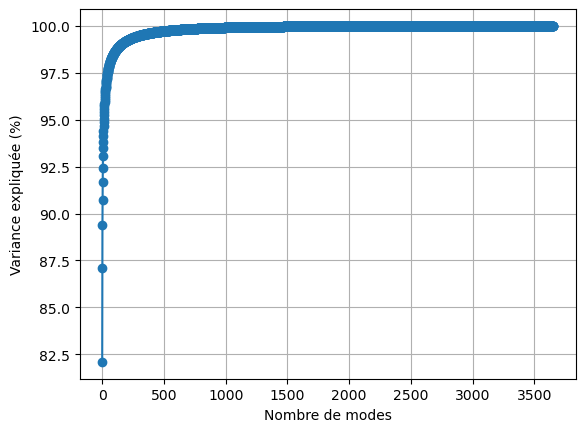

In [4]:
X = sstStacked.values  # shape (Nt, Nspace)

pca = PCA(svd_solver="full")
PCs = pca.fit_transform(X)

explainedVar = pca.explained_variance_ratio_

plt.figure()
plt.plot(np.cumsum(explainedVar)*100, marker="o")
plt.xlabel("Nombre de modes")
plt.ylabel("Variance expliquée (%)")
plt.grid()
plt.show()



La variance expliquée cumulée montre que l’essentiel de la variabilité des anomalies de SST est capturé par un nombre limité de modes EOF, indiquant une dynamique de faible dimension effective. C'est à dire que son évolution est gouvernée par un **nombre réduit de degrées de liberté**, cela malgré que le système soit décrit par un grand nombre de variable. Faible dimension = prévisible, compressible et modélisable en peu d'états.

&nbsp;

> #### Mais alors, quel est le nombre idéal de mode à conserver pour la réduction de dimensionnalité ?

Le nombre idéal de modes est le plus petit nombre $K$ tel que l’on conserve l’essentiel de la dynamique tout en éliminant le bruit ($K$ le nombre de mode retenu pour la réduction). On va chercher un compromis entre trop peu (perte d'informations) et trop (bruit et/ou sur-paramétrisation).

Plusieurs méthodes sont possibles pour déterminer ce paramètre :
- La méthode du coude. Par visualisation du scree plot, on cherche le point où la pente devient faible.
- Par seuil arbitraire de variance expliquée. Par standard, on dira qu'on peut choisir $K$ tel que la variance expliquée cumulée est supérieur à 90%.
- L'erreur de reconstruction. Une méthode plus avancée dans laquelle on calcule l'erreur suivante : $ || X - \hat X_K||$. Quand elle décroit lentement, on estime que K est suffisant.

Les 2 première méthodes sont populaires mais peu justifiable selon nous. On va donc préférer utiliser la 3ème méthode.

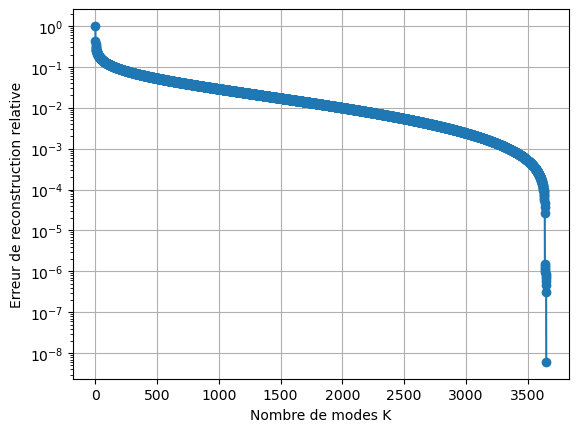

In [5]:
singularValues = pca.singular_values_

totalEnergy = np.sum(singularValues**2)

reconstructionError = [
    np.sqrt(np.sum(singularValues[k:]**2) / totalEnergy)
    for k in range(len(singularValues))
]

plt.figure()
plt.plot(reconstructionError, marker="o")
plt.xlabel("Nombre de modes K")
plt.ylabel("Erreur de reconstruction relative")
plt.yscale("log")
plt.grid()
plt.show()


Le plot est bien de la forme attendue, on peut désormais deux critères simples mais pertinents pour déterminer un intervalle pour $K$.

In [6]:
# 1st criterion : fixed threshold on reconstruction error

error = np.array(reconstructionError)

threshold1 = 0.10
threshold2 = 0.05
threshold3 = 0.03

KOpt1 = np.argmax(error <= threshold1)
KOpt2 = np.argmax(error <= threshold2)
KOpt3 = np.argmax(error <= threshold3)

print("Nombre de modes retenus :", KOpt1, "pour une erreur <=", threshold1)
print("Nombre de modes retenus :", KOpt2, "pour une erreur <=", threshold2)
print("Nombre de modes retenus :", KOpt3, "pour une erreur <=", threshold3)




Nombre de modes retenus : 152 pour une erreur <= 0.1
Nombre de modes retenus : 533 pour une erreur <= 0.05
Nombre de modes retenus : 964 pour une erreur <= 0.03


In [7]:
# 2nd criterion : marginal residual energy (differential criterion)

deltaError = np.abs(np.diff(error))

deltaThreshold1 = 1e-3
deltaThreshold2 = 5e-4
deltaThreshold3 = 1e-4

KOpt1 = np.argmax(deltaError < deltaThreshold1)
KOpt2 = np.argmax(deltaError < deltaThreshold2)
KOpt3 = np.argmax(deltaError < deltaThreshold3)

print("Nombre de modes retenus (delta) :", KOpt1, "pour un delta d'erreur <", deltaThreshold1)
print("Nombre de modes retenus (delta) :", KOpt2, "pour un delta d'erreur <", deltaThreshold2)
print("Nombre de modes retenus (delta) :", KOpt3, "pour un delta d'erreur <", deltaThreshold3)


Nombre de modes retenus (delta) : 49 pour un delta d'erreur < 0.001
Nombre de modes retenus (delta) : 90 pour un delta d'erreur < 0.0005
Nombre de modes retenus (delta) : 381 pour un delta d'erreur < 0.0001


En cadrillant à partir de plusieurs seuils, on peut désormais déterminer un intervalle pertinent pour $K$. On exclut les valeurs qui divergent "brutalement" (533, 964 et 381). Ce qui nous laisse 49, 90 et 152 comme valeurs retenues selon les seuils. On a donc $K$ idéal $\in [50, 150]$. Intervalle sur lequel on choisira arbitrairement la valeur au centre (la méthode pour déterminer $K$ étant selon nous robuste, on choisit la variable la plus évidente).

On retiendra donc $ K = 100 $.

&nbsp;

---

&nbsp;

## 5. Analyse des modes spatiaux dominants (EOF)

Pour s'assurer de la pertinence des modes spatiaux sortis de notre EOF, nous pouvons essayer d'interpréter qualitativement les cartes spatiales reconstituées avec les composants de la PCA. Scientifiquement, cela nous permet de répondre à la question **"Où les dynamiques se manifestent ?"**.

Les modes EOF représentent des structures statistiques optimales au sens de la variance, et ne correspondent pas nécessairement à des mécanismes physiques indépendants.

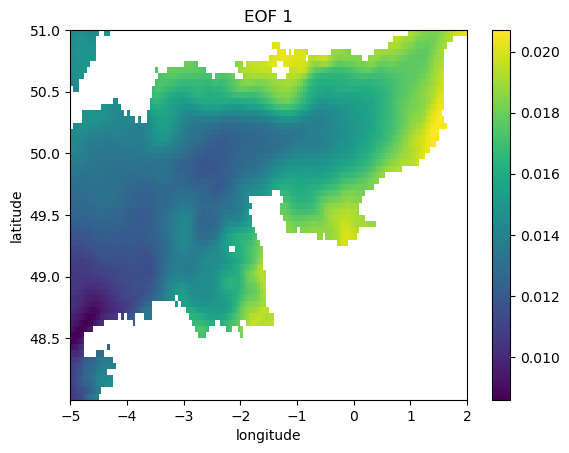

In [10]:
EOFs = xr.DataArray(
    pca.components_,
    dims=("mode", "space"),
    coords={"mode": np.arange(pca.n_components_),
            "space": sstStacked.space}
)

EOFs = EOFs.unstack("space")

EOFs.isel(mode=0).plot()
plt.title("EOF 1")
plt.show()

On observe une structure spatiale *a priori* cohérente (+ pas de bruits granulaires). On constate des valeur fortes côté côte-est, et des valeurs plus faibles côté large-ouest. 

L'EOF 1 est le mode dominant de variabilité spatiale, il semble être caractérisé par un gradient côte-large.

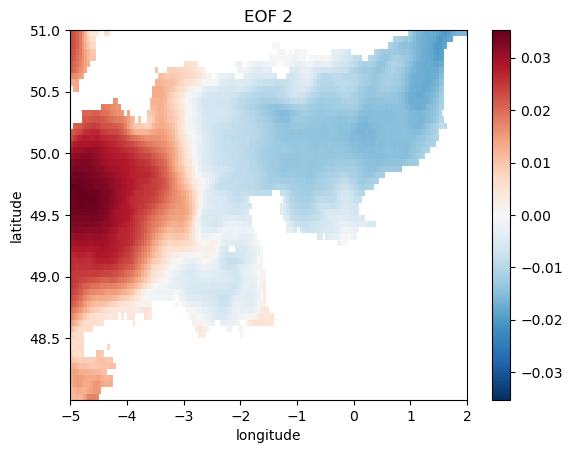

In [11]:
EOFs.isel(mode=1).plot()
plt.title("EOF 2")
plt.show()

On observe un net changement de signe entre la zone plus ouverte Ouest de la Manche (positif) et les zones plus fermées Est (négatif). La structure est plus large échelle (moins de variations locales). La transition spatiale est progressive. 

L'EOF 2 correspond à un mode de contraste type longitudinale (une manière dont les anomalies vont s'organiser d'Ouest en Est), opposant l'influence de l'Atlantique aux masses d'eaux côtières et moins ouvertes.

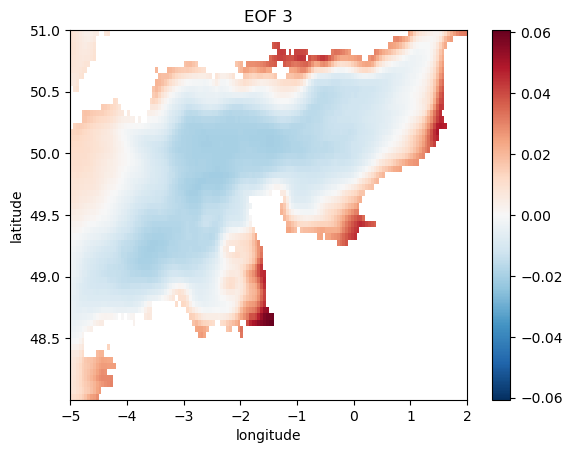

In [12]:
EOFs.isel(mode=2).plot()
plt.title("EOF 3")
plt.show()

On observe un mode toujours spatialement cohérent mais moins global. La structure s'approche plus d'une méso-échelle (une échelle intermédiaire entre quelques kilomètres et quelques centaines de kilomètres). Les changements de signes se font à une échelle beaucoup plus locale et toujours assez proche des côtes.

On peut assez difficilement donner une hypothèse d'interprétation fiable pour l'EOF 3. Le mode semble lié aux courants côtiers, aux fronts thermiques et à la bathymétrie mais aucunes certitudes.

&nbsp;

Globalement, les modes dominants semblent interprétables (les EOF 1, 2 et 3 sont physiquement significatifs) ce qui laisse présager une faible dimension effective et une réduction de dimension légitime. Cela renforce notre assurance concernant l'authenticité des modes spatiaux. Le nombre $K$ de modes choisies restent également pertinent.

&nbsp;

---

&nbsp;

## 6. Analyse des coefficients temporels (PC)

Les PCs sont les états temporels du système projetés dans un espace réduit. Ici cela correspondrait à répondre **"Quand et avec quelle intensité les dynamiques se manifestent-elles ?"**.

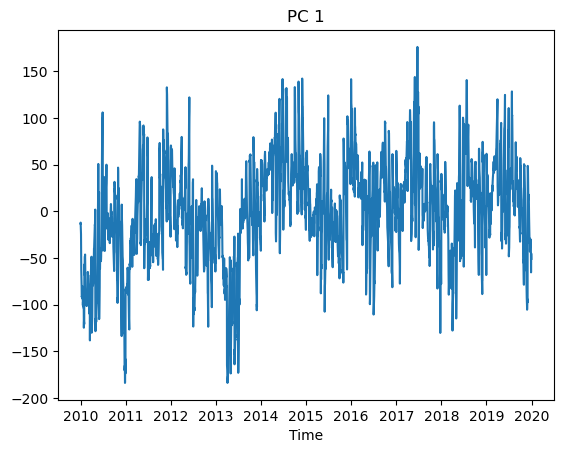

In [13]:
PCs = xr.DataArray(
    PCs,
    dims=("time", "mode"),
    coords={"time": sst.time,
            "mode": np.arange(pca.n_components_)}
)

PCs.isel(mode=0).plot()
plt.title("PC 1")
plt.show()

La série temporelle semble être centrée autour de 0 et on ne constate pas de dérive évidente. Cela nous confirme, jusqu'à preuve du contraire, un bon centrage, une stationnarité acceptable et une PCA correctement appliquée.

&nbsp;

> #### Que décrivent les PCs (Principal Components) ?

Ils décrivent l'intensité temporelle du mode EOF associé. PC1 nous indique que la structure EOF 1 est renforcée quand celui-ci est positif (proportionnelement à l'amplitude), et vice-versa.

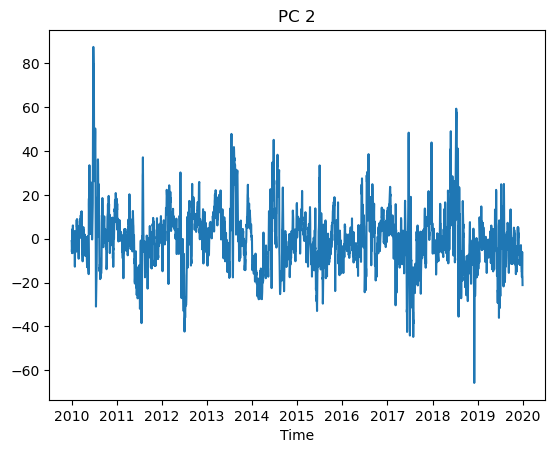

In [14]:
PCs.isel(mode=1).plot()
plt.title("PC 2")
plt.show()

La série temporelle est toujours vraisemblablement centrée en 0. Les fluctuations sur l'axe des ordonnées sont plus "rapides" que pour PC1. On remarque une certaine variabiltié intermittente (alternance de périodes calmes et d'épisodes à forte amplitude). Toujours pas de dérives long termes.

En partant de notre interprétation pour EOF 2, on pourrait désormais déterminer des périodes d'influences plutôt de l'Atlantique ou plutôt des zones moins ouvertes/côtières. Les pics pourraient correspondre à des épisodes atmosphériques marqués.

&nbsp;

---

&nbsp;

## 7. Implication pour le SciML

La décomposition EOF n'est pas juste une analyse descriptive, mais un changement de base. Le champs spatial-temporel initial est projeté sur une base spatiale orthogonale et optimisée dans laquelle les degrés de liberté spatiaux sont condensés. La composante temporelle dans ce contexte est éliminée, c'est-à-dire que les modes EOF sont fixes dans le temps.

Toute la dynamique pertinente en elle-même est désormais entièrement portée par l'évolution des PCs associés. On ne modélise plus un champs mais un vecteur d'état composé des PCs, soit mathématiquement :

$$
\dot{a_k}(t) = f(\begin{pmatrix} a_1(t) \\ a_2(t) \\ \vdots \\ a_k(t) \end{pmatrix})
$$
où : 
- $a_1(t)$ : amplitude du mode EOF 1
- $a_2(t)$ : amplitude du mode EOF 2
- ...
- $a_3(t)$ : amplitude du mode EOF 3

Ensemble, ils forment l'état dynamique réduit du système. Le modèle SciML apprendra donc :

$$
\dot{a_k}(t) = \begin{pmatrix} \dot{a_1}(t) \\ \dot{a_2}(t) \\ \vdots \\ \dot{a_k}(t) \end{pmatrix} = f_\theta(a_1(t), a_2(t),..., a_k(t))
$$

Chaque équation dépend potentiellement de tous les PCs.
